In [1]:
# Libraries
library(tidyverse) # ggplot(.)
library(glmnet) # for regularised regression
# Read dataset
df <- read.csv("HornsRev.csv")
# Set Impact as factor
df$Impact <- as.factor(df$Impact)

── Attaching packages ──────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.2     ✔ forcats 0.5.1

Warning message:
“package ‘ggplot2’ was built under R version 4.1.1”
Warning message:
“package ‘tibble’ was built under R version 4.1.1”
Warning message:
“package ‘readr’ was built under R version 4.1.1”
Warning message:
“package ‘stringr’ was built under R version 4.1.1”
Warning message:
“package ‘forcats’ was built under R version 4.1.1”
── Conflicts ─────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1-2



In [2]:
glmFitOD3Scale <- glm(Nhat ~ Impact*scale(XPos) + Impact*scale(YPos) + scale(Depth),
offset=log(Area), family=quasipoisson, data=df)

In [3]:
xmatrix <- model.matrix(glmFitOD3Scale)
xmatrix <- xmatrix[, 2:ncol(xmatrix)]

In [4]:
ridge <- glmnet(xmatrix, df$Nhat, family="poisson", offset=log(df$Area), alpha=0)
cvridge <- cv.glmnet(xmatrix, df$Nhat, family="poisson", offset=log(df$Area), alpha=0, nfolds=10)

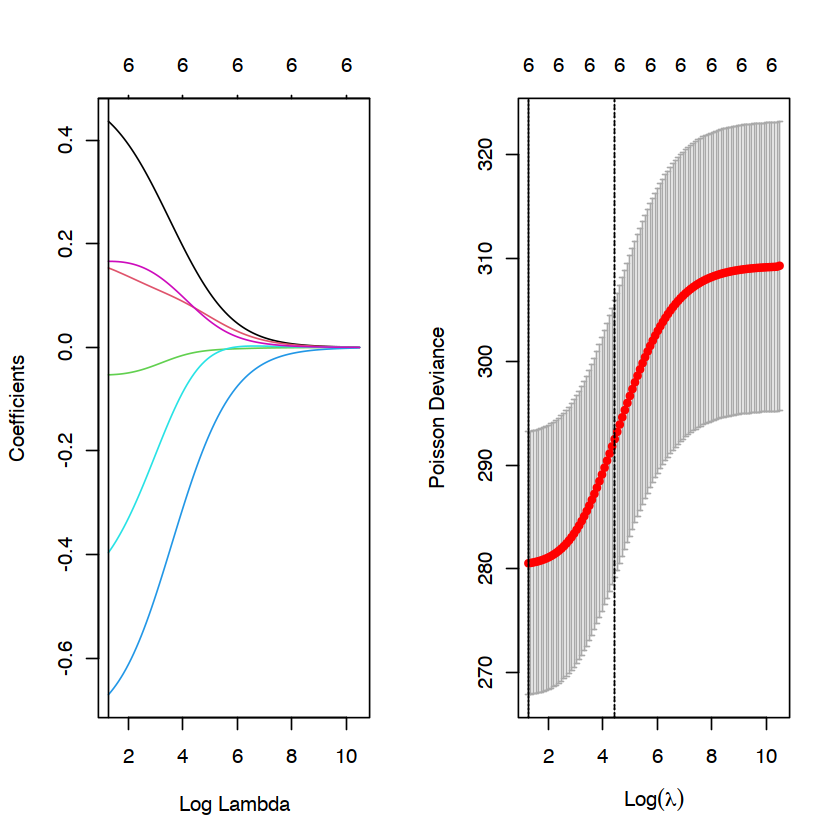

In [5]:
par(mfrow=c(1, 2))
plot(ridge, xvar="lambda")
abline(v=log(cvridge$lambda.min))
plot(cvridge)
abline(v=log(cvridge$lambda.min))
abline(v=log(cvridge$lambda.1se), lty=2)

In [46]:
log(cvridge$lambda.min)

[1] 1.277964

In [6]:
# quasi-Poisson fit
coefGLM <- as.data.frame(coef(glmFitOD3Scale))
colnames(coefGLM) <- "GLM"
coefGLM$Covariate <- row.names(coefGLM)
# Add 95% confidence intervals
confInt <- as.data.frame(confint(glmFitOD3Scale, level=0.95))
colnames(confInt) <- c("CI_Lower", "CI_Upper")
confInt$Covariate <- row.names(confInt)
# Merge together
coefGLM <- dplyr::inner_join(coefGLM, confInt, by="Covariate")
# Ridge regression
coefRidge <- as.data.frame(as.matrix(coef(cvridge, s="lambda.min")))
colnames(coefRidge) <- "Ridge"
coefRidge$Covariate <- row.names(coefRidge)
# Merge data frames
mdlCoefs <- dplyr::inner_join(coefGLM, coefRidge, by="Covariate")
mdlCoefs=mdlCoefs
# Display differences
print(mdlCoefs)

Waiting for profiling to be done...



          GLM           Covariate    CI_Lower    CI_Upper       Ridge
1  3.60988598         (Intercept)  3.50631159  3.70994357  3.68630640
2  0.49558483             Impact1  0.37421498  0.61832705  0.43683300
3  0.18320221         scale(XPos)  0.08159963  0.28465940  0.15360005
4 -0.04941963         scale(YPos) -0.15533586  0.05542462 -0.05292261
5 -0.73732840        scale(Depth) -0.81122462 -0.66383602 -0.67083601
6 -0.48826771 Impact1:scale(XPos) -0.62177810 -0.35501937 -0.39637023
7  0.15875897 Impact1:scale(YPos)  0.01419731  0.30384692  0.16638849


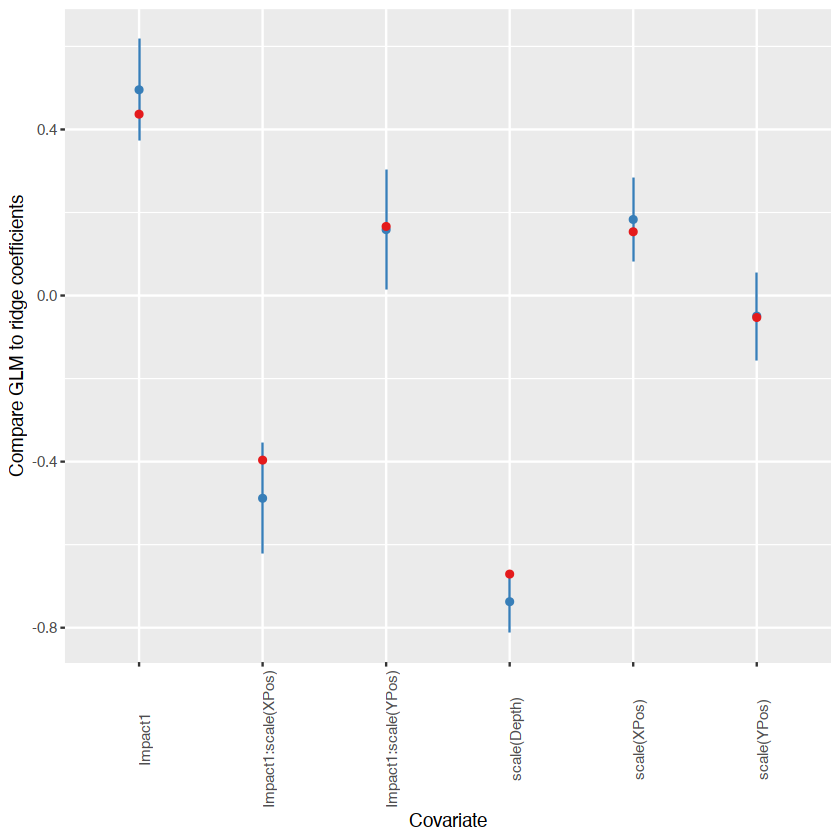

In [7]:
ggplot(subset(mdlCoefs, !Covariate %in% "(Intercept)")) +
   geom_point(aes(x=Covariate, y=GLM), col="#377eb8") +
   geom_linerange(aes(x=Covariate, ymin=CI_Lower, ymax=CI_Upper),
   col="#377eb8") +
geom_point(aes(x=Covariate, y=Ridge), col="#e41a1c") +
ylab("Compare GLM to ridge coefficients") +
theme(axis.text.x=element_text(angle=90),
legend.position="none")

In [8]:
ifelse(mdlCoefs$Ridge > mdlCoefs$CI_Lower & mdlCoefs$Ridge < mdlCoefs$CI_Upper, TRUE, FALSE)

[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE

In [9]:
lasso <- glmnet(xmatrix, df$Nhat, family="poisson", offset=log(df$Area), alpha=1)
cvlasso <- cv.glmnet(xmatrix, df$Nhat, family="poisson", offset=log(df$Area), alpha=1, nfolds=10)

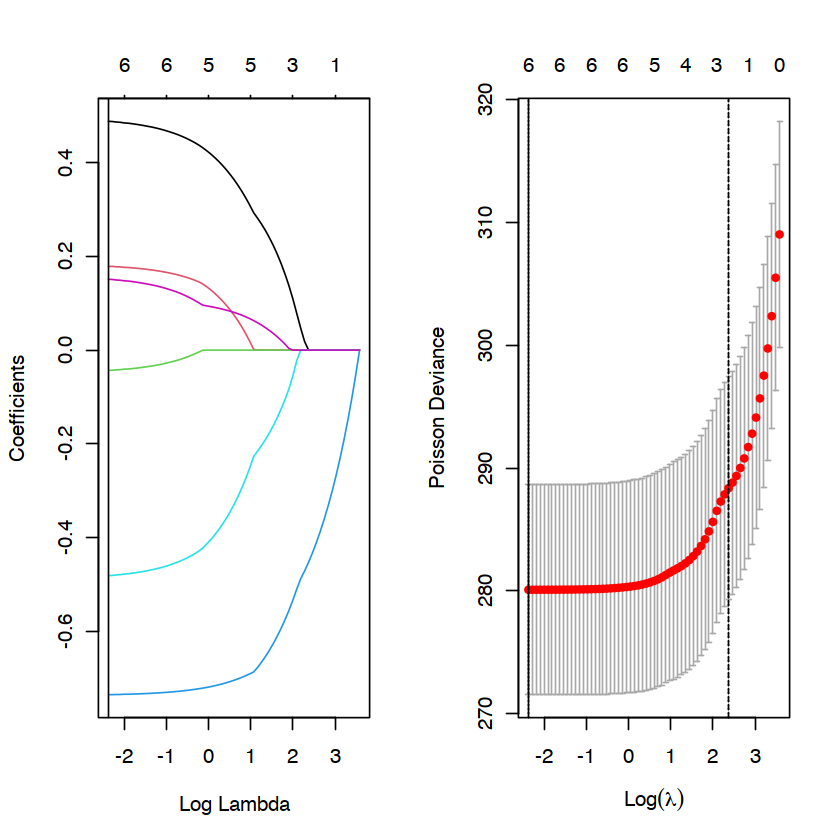

In [10]:
par(mfrow=c(1, 2))
plot(lasso, xvar="lambda")
abline(v=log(cvlasso$lambda.min))
plot(cvlasso)
abline(v=log(cvlasso$lambda.min))
abline(v=log(cvlasso$lambda.1se), lty=2)

In [47]:
log(cvlasso$lambda.min)

[1] -2.373611

In [48]:
cvlasso$lambda.min

[1] 0.09314382

In [11]:
# quasi-Poisson fit
coefGLM <- as.data.frame(coef(glmFitOD3Scale))
colnames(coefGLM) <- "GLM"
coefGLM$Covariate <- row.names(coefGLM)
# Add 95% confidence intervals
confInt <- as.data.frame(confint(glmFitOD3Scale, level=0.95))
colnames(confInt) <- c("CI_Lower", "CI_Upper")
confInt$Covariate <- row.names(confInt)
# Merge together
coefGLM <- dplyr::inner_join(coefGLM, confInt, by="Covariate")
# Ridge regression
coefLasso <- as.data.frame(as.matrix(coef(cvlasso, s="lambda.min")))
colnames(coefLasso) <- "Lasso"
coefLasso$Covariate <- row.names(coefLasso)
# Merge data frames
mdlCoefs <- dplyr::inner_join(coefGLM, coefLasso, by="Covariate")
mdlCoefs=mdlCoefs
# Display differences
print(mdlCoefs)

Waiting for profiling to be done...



          GLM           Covariate    CI_Lower    CI_Upper       Lasso
1  3.60988598         (Intercept)  3.50631159  3.70994357  3.61691652
2  0.49558483             Impact1  0.37421498  0.61832705  0.48813958
3  0.18320221         scale(XPos)  0.08159963  0.28465940  0.17874957
4 -0.04941963         scale(YPos) -0.15533586  0.05542462 -0.04330364
5 -0.73732840        scale(Depth) -0.81122462 -0.66383602 -0.73531484
6 -0.48826771 Impact1:scale(XPos) -0.62177810 -0.35501937 -0.48132871
7  0.15875897 Impact1:scale(YPos)  0.01419731  0.30384692  0.15103834


In [12]:
ifelse(mdlCoefs$Lasso > mdlCoefs$CI_Lower & mdlCoefs$Lasso < mdlCoefs$CI_Upper, TRUE, FALSE)

[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE

### elastic-net

In [25]:
enet <- glmnet(xmatrix, df$Nhat, family="poisson", offset=log(df$Area), alpha=0.6)
cvenet <- cv.glmnet(xmatrix, df$Nhat, family="poisson", offset=log(df$Area), alpha=0.6, nfolds=10)

In [50]:
log(cvenet$lambda.min)

[1] -1.955819

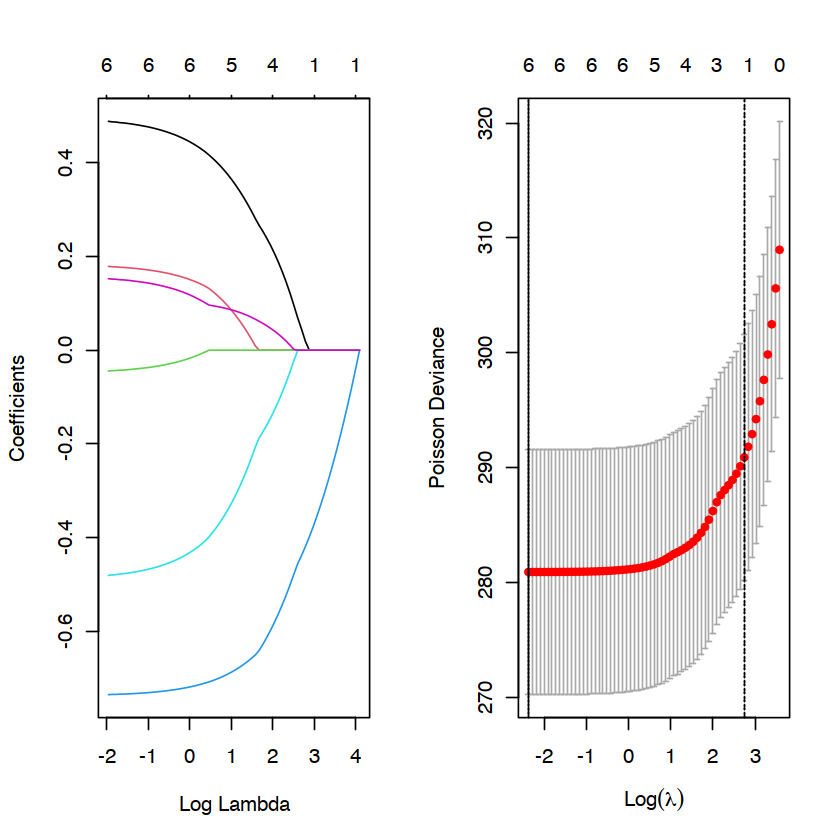

In [14]:
par(mfrow=c(1, 2))
plot(enet, xvar="lambda")
abline(v=log(cvenet$lambda.min))
plot(cvenet)
abline(v=log(cvenet$lambda.min))
abline(v=log(cvenet$lambda.1se), lty=2)

In [26]:
# quasi-Poisson fit
coefGLM <- as.data.frame(coef(glmFitOD3Scale))
colnames(coefGLM) <- "GLM"
coefGLM$Covariate <- row.names(coefGLM)
# Add 95% confidence intervals
confInt <- as.data.frame(confint(glmFitOD3Scale, level=0.95))
colnames(confInt) <- c("CI_Lower", "CI_Upper")
confInt$Covariate <- row.names(confInt)
# Merge together
coefGLM <- dplyr::inner_join(coefGLM, confInt, by="Covariate")
# Ridge regression
coefEnet <- as.data.frame(as.matrix(coef(cvenet, s="lambda.min")))
colnames(coefEnet) <- "enet"
coefEnet$Covariate <- row.names(coefEnet)
# Merge data frames
mdlCoefs <- dplyr::inner_join(coefGLM, coefEnet, by="Covariate")
mdlCoefs=mdlCoefs
# Display differences
print(mdlCoefs)

Waiting for profiling to be done...



          GLM           Covariate    CI_Lower    CI_Upper       enet
1  3.60988598         (Intercept)  3.50631159  3.70994357  3.6174532
2  0.49558483             Impact1  0.37421498  0.61832705  0.4879153
3  0.18320221         scale(XPos)  0.08159963  0.28465940  0.1786207
4 -0.04941963         scale(YPos) -0.15533586  0.05542462 -0.0443620
5 -0.73732840        scale(Depth) -0.81122462 -0.66383602 -0.7344738
6 -0.48826771 Impact1:scale(XPos) -0.62177810 -0.35501937 -0.4802499
7  0.15875897 Impact1:scale(YPos)  0.01419731  0.30384692  0.1524286


In [36]:
mdlCoefs$Lasso = coef(cvlasso, s="lambda.min")[,1]
mdlCoefs$Ridge = coef(cvridge, s="lambda.min")[,1]

In [37]:
mdlCoefs

GLM,Covariate,CI_Lower,CI_Upper,enet,Lasso,Ridge
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3.60988598,(Intercept),3.50631159,3.70994357,3.6174532,3.61691652,3.68630640
0.49558483,Impact1,0.37421498,0.61832705,0.4879153,0.48813958,0.43683300
0.18320221,scale(XPos),0.08159963,0.28465940,0.1786207,0.17874957,0.15360005
-0.04941963,scale(YPos),-0.15533586,0.05542462,-0.0443620,-0.04330364,-0.05292261
-0.73732840,scale(Depth),-0.81122462,-0.66383602,-0.7344738,-0.73531484,-0.67083601
-0.48826771,Impact1:scale(XPos),-0.62177810,-0.35501937,-0.4802499,-0.48132871,-0.39637023
0.15875897,Impact1:scale(YPos),0.01419731,0.30384692,0.1524286,0.15103834,0.16638849


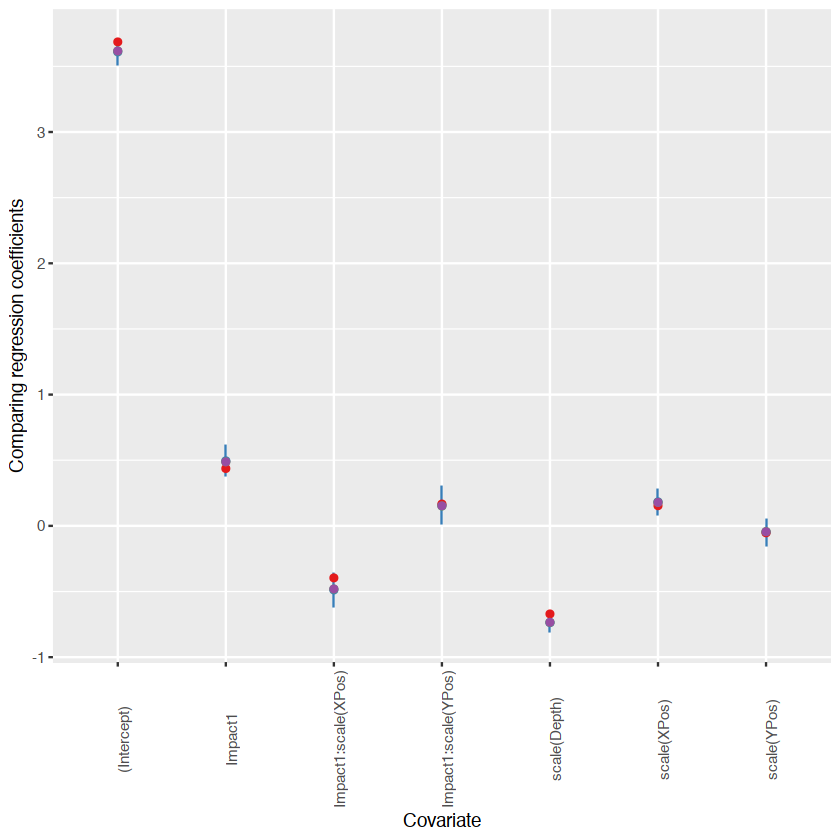

In [38]:
ggplot(mdlCoefs) +
geom_point(aes(x=Covariate, y=GLM), col="#377eb8") +
geom_linerange(aes(x=Covariate, ymin=CI_Lower, ymax=CI_Upper),
col="#377eb8") +
geom_point(aes(x=Covariate, y=Ridge), col="#e41a1c") +
geom_point(aes(x=Covariate, y=Lasso), col="#4daf4a") +
geom_point(aes(x=Covariate, y=enet), col="#984ea3") +
ylab("Comparing regression coefficients") +
theme(axis.text.x=element_text(angle=90),
legend.position="none")

In [41]:
glmCoef <- mdlCoefs[, c("GLM", "CI_Lower", "CI_Upper", "Covariate")]
# Remove GLM results from mdlCoefsFake
# Note: the function "select" conflicts with the one in the MASS package
# which is loaded by glmnet so you have to be explicit when calling this function
mdlCoefs <- mdlCoefs %>%
dplyr::select(-c("GLM", "CI_Lower", "CI_Upper"))
head(mdlCoefs)

,Covariate,enet,Lasso,Ridge
,<chr>,<dbl>,<dbl>,<dbl>
1,(Intercept),3.6174532,3.61691652,3.68630640
2,Impact1,0.4879153,0.48813958,0.43683300
3,scale(XPos),0.1786207,0.17874957,0.15360005
4,scale(YPos),-0.0443620,-0.04330364,-0.05292261
5,scale(Depth),-0.7344738,-0.73531484,-0.67083601
6,Impact1:scale(XPos),-0.4802499,-0.48132871,-0.39637023


In [43]:
mdlCoefs

Covariate,Model,Coef
<chr>,<chr>,<dbl>
(Intercept),enet,3.61745324
Impact1,enet,0.48791533
scale(XPos),enet,0.17862072
scale(YPos),enet,-0.04436200
scale(Depth),enet,-0.73447381
Impact1:scale(XPos),enet,-0.48024986
Impact1:scale(YPos),enet,0.15242861
(Intercept),Lasso,3.61691652
Impact1,Lasso,0.48813958


In [42]:
mdlCoefs <- mdlCoefs %>%
gather(-Covariate, key="Model", value="Coef")
head(mdlCoefs)

,Covariate,Model,Coef
,<chr>,<chr>,<dbl>
1,(Intercept),enet,3.6174532
2,Impact1,enet,0.4879153
3,scale(XPos),enet,0.1786207
4,scale(YPos),enet,-0.0443620
5,scale(Depth),enet,-0.7344738
6,Impact1:scale(XPos),enet,-0.4802499


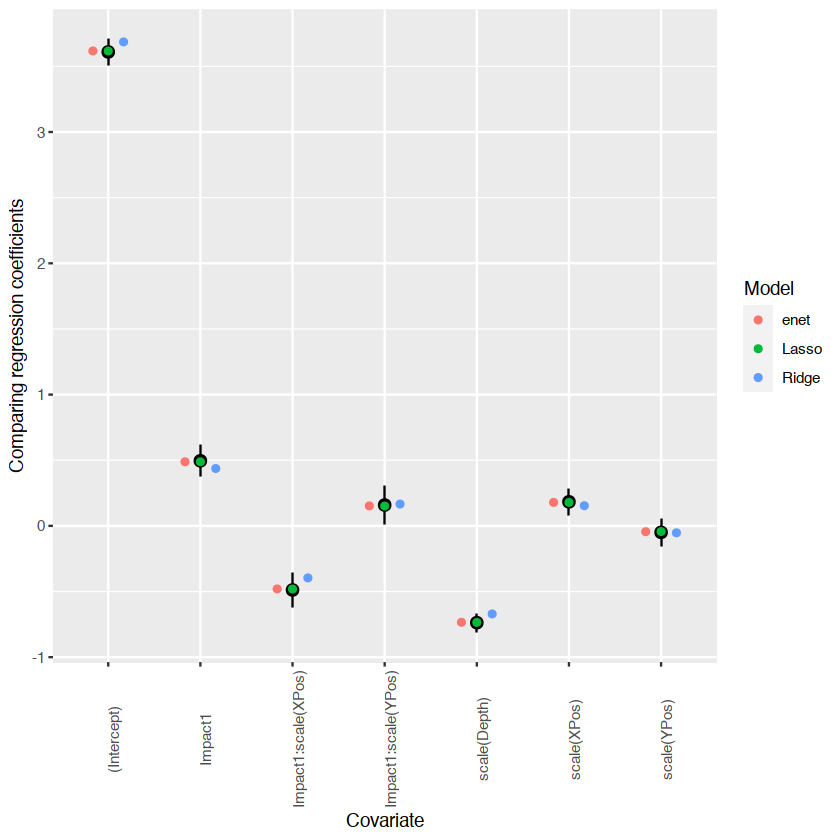

In [44]:
ggplot() +
geom_pointrange(aes(x=Covariate, y=GLM, ymin=CI_Lower, ymax=CI_Upper),
col="black", data=glmCoef) +
geom_point(aes(x=Covariate, y=Coef, col=Model), data=mdlCoefs,
position=position_dodge(width=0.5)) +
ylab("Comparing regression coefficients") +
theme(axis.text.x=element_text(angle=90))

In [52]:
min(cvridge$cvm)

[1] 280.5477

In [53]:
min(cvlasso$cvm)

[1] 280.0945

In [54]:
min(cvenet$cvm)

[1] 280.0095